# Use Python <3.10

This package heavily utilizes the pyMuellerMat package that makes Mueller matrices from "system dictionaries" detailing the instrument configuration. Make sure to clone the physical_models branch of pyMuellerMat at https://github.com/maxwellmb/pyMuellerMat/.

In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *

# Step 3 (Optional): Plot Your Data With the Original Model 

In [33]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# I have bin 15 here, I would recommend using a bin in the middle to get a good idea,
# bin zero can be finicky
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  144
[-5.29888721e-01  3.94488401e+08 -3.97088140e-01  3.94805602e+08
 -2.57682445e-02  3.91964053e+08  3.80099386e-01  3.91815292e+08
  5.88668204e-01  3.92806254e+08]
Interleaved Stds
Length:  144
[4.26985511e-05 1.98617321e+04 4.61899150e-05 1.98697157e+04
 5.04931710e-05 1.97980821e+04 4.67278203e-05 1.97943248e+04
 4.07871675e-05 1.98193404e+04]
Configuration List
Length:  72
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 90.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'th

In [5]:

# Define wavelength bins for CHARIS

wavelength_bins = np.array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
2139.4131, 2213.4641, 2290.0781, 2369.3441])

# Loading in past fits from Joost t Hart 2021

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.49999981  0.49999944 -0.00061086  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


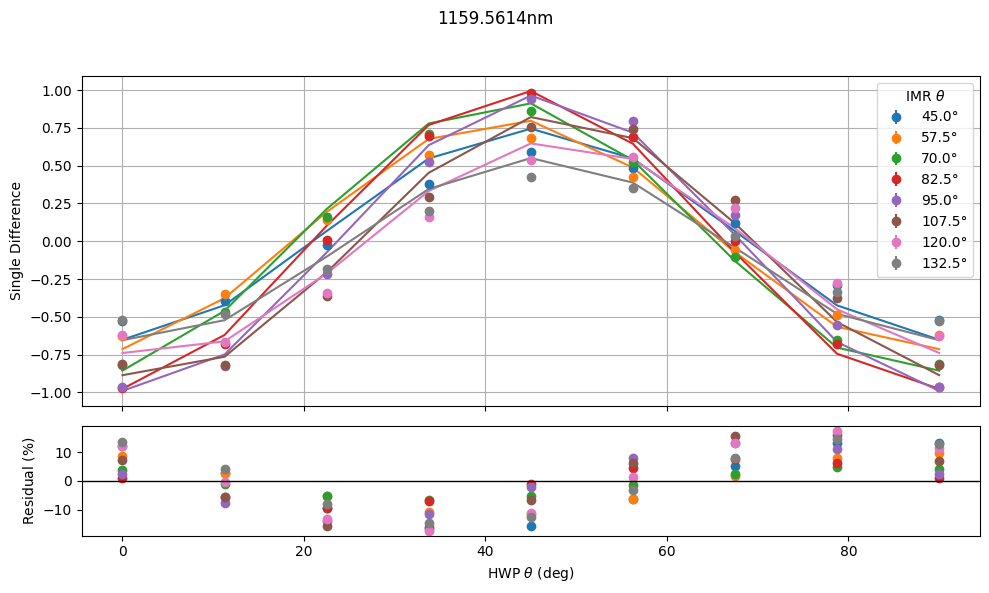

Residuals range: -0.17317608428253528 0.17387977665606325


In [6]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[15], IMR_retardance(wavelength_bins)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values

plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[0], mode='CHARIS')

# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


# Step 4: Fit New Model

In [54]:
def fit_CHARIS_Mueller_matrix_offsets_by_bin(csv_path, wavelength_bin, new_config_dict_path,plot_path=None):
    """
    Fits a Mueller matrix for one wavelength bin from internal calibration data and saves
    the updated configuratio dictionary to a JSON file. Creates a plot
    of each updated model vs the data. Initial guesses for all fits are from Joost t Hart 2021.
    Note that following the most recent model update these guesses should be updated.
    The csv containing the calibration data and relevant headers can be obtained by 
    the write_fits_info_to_csv function in instruments.py. This code currently fits for
    derotator retardance/offset, HWP retardance/offset, and calibration polarizer offset.
    It can be modified relatively easily to fit for other parameters as well. CURRENT 
    PARAMETERS: IMR retardance, HWP retardance, calibration polarizer diattenuation. 

    Parameters
    ----------
    csv_path : str or Path
        Path to the CSV file containing the calibration data. Must contain the columns "D_IMRANG", 
    "RET-ANG1", "single_sum", "norm_single_diff", "diff_std", and "sum_std".

    wavelength_bin : int
        The index of the wavelength bin to fit (0-21 for CHARIS).

    new_system_dict_path : str or Path
        Path to save the new system dictionary as a JSON file. The config dict
        component names will be 'lp' for calibration polarizer, 'image_rotator' for image rotator,
        and 'hwp' for half-wave plate.

    plot_path : str or Path, optional
        Path to save the plot of the observed vs modeled data. If not provided, no plot will be saved.
        Must have a .png extension.
    
    Returns
    -------
    error : np.array
      An array of the errors for each parameter. 
    """
    # Check file paths
    filepath = Path(csv_path)
    if not filepath.exists() or filepath.suffix != ".csv":
        raise ValueError("Please provide a valid .csv file.")
    plot_path = Path(plot_path)
    if plot_path.suffix != ".png":
        raise ValueError("Please provide a valid .png file for plotting.")
    if new_config_dict_path.suffix != ".json":
        raise ValueError("Please provide a valid .json file for saving the new system dictionary.")
    new_config_dict_path = Path(new_config_dict_path)
    # Read in data

    interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
    print(configuration_list)
    # Loading in past fits 

    offset_imr = -0.01062 # derotator offset
    offset_hwp = -0.0022 # HWP offset
    offset_cal = -0.0315 # calibration polarizer offset
    imr_theta = 0 # placeholder 
    hwp_theta = 0 # placeholder
    imr_phi = IMR_retardance(np.array(wavelength_bins[wavelength_bin]),d=259.14685)[0]
    hwp_phi = HWP_retardance(np.array(wavelength_bins[wavelength_bin]),w_SiO2=1.64905,w_MgF2=1.28768)[0]
    epsilon_cal = 1

    # Define instrument configuration as system dictionary
    # Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o'}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": imr_theta, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": hwp_theta, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": epsilon_cal, "delta_theta": offset_cal },
                    "tag": "internal",
                }}
        }

    # Converting system dictionary into system Mueller Matrix object

    system_mm = generate_system_mueller_matrix(system_dict)

    # Define initial guesses for our parameters 
    # Modify this if you want to change the parameters

    p0 = {
        "image_rotator" : 
            {"delta_theta": offset_imr},
        "hwp" :  
            {"delta_theta": offset_hwp},
        "lp" : 
            {"delta_theta": offset_cal }
    }

    # Define some bounds
    # Modify this if you want to change the parameters or minimization bounds
    offset_bounds = (-5,5)
    hwpstd = 0.1*np.abs(hwp_phi)
    hwp_phi_bounds = (hwp_phi-hwpstd, hwp_phi+hwpstd)
    imrstd = 0.1*np.abs(imr_phi)
    imr_phi_bounds = (imr_phi-imrstd, imr_phi+imrstd)
    imrostd = 0.1*np.abs(offset_imr)
    offset_imr_bounds = (offset_imr-imrostd, offset_imr+imrostd)
    hwpostd = 0.1*np.abs(offset_hwp)
    offset_hwp_bounds = (offset_hwp-hwpostd, offset_hwp+hwpostd)
    epsilon_cal_bounds = (0.9*epsilon_cal, 1)
    calostd = 0.1 *np.abs(offset_cal)
    offset_cal_bounds = (offset_cal-calostd, offset_cal+calostd)

    # Minimize the system Mueller matrix using the interleaved values and standard deviations
    # Modify this if you want to change the parameters

    # Counters for iterative fitting

    iteration = 1
    previous_logl = 1000000
    new_logl = 0

    # Perform iterative fitting

    while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
        if iteration > 1:
            previous_logl = new_logl
        result, new_logl, error = minimize_system_mueller_matrix(p0, system_mm, interleaved_values, 
            interleaved_stds, configuration_list, bounds = [offset_bounds,offset_bounds,offset_bounds],mode='CHARIS')
        print(result)

        # Update p0 with new values

        update_p0(p0, result.x)
        iteration += 1


    # Update p dictionary with the fitted values

    update_p0(p0, result.x)

    # Process model

    p0_values, p0_keywords = parse_configuration(p0)

    # Generate modeled left and right beam intensities

    updated_system_mm = update_system_mm(result.x, p0_keywords, system_mm)

    # Generate modeled left and right beam intensities

    LR_intensities2 = model(p0_values, p0_keywords, updated_system_mm, configuration_list)

    # Process these into interleaved single normalized differences and sums

    diffs_sums2 = process_model(LR_intensities2, 'CHARIS')

    # Plot the modeled and observed values

    plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums2,configuration_list, wavelength= wavelength_bins[wavelength_bin], mode='CHARIS',save_path=plot_path)

    # Print the Mueller matrix

    print("Updated Mueller Matrix:")
    print(updated_system_mm.evaluate())

    # Print residuals

    residuals = interleaved_values[::2] - diffs_sums2[::2]
    print("Residuals range:", residuals.min(), residuals.max())
    print("Error:", error)

    # Save system dictionary to a json file

    with open (new_config_dict_path, 'w') as f:
        json.dump(p0, f, indent=4)
    error = np.array(error)
    return error



[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 90.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 78.75}, 'image_r

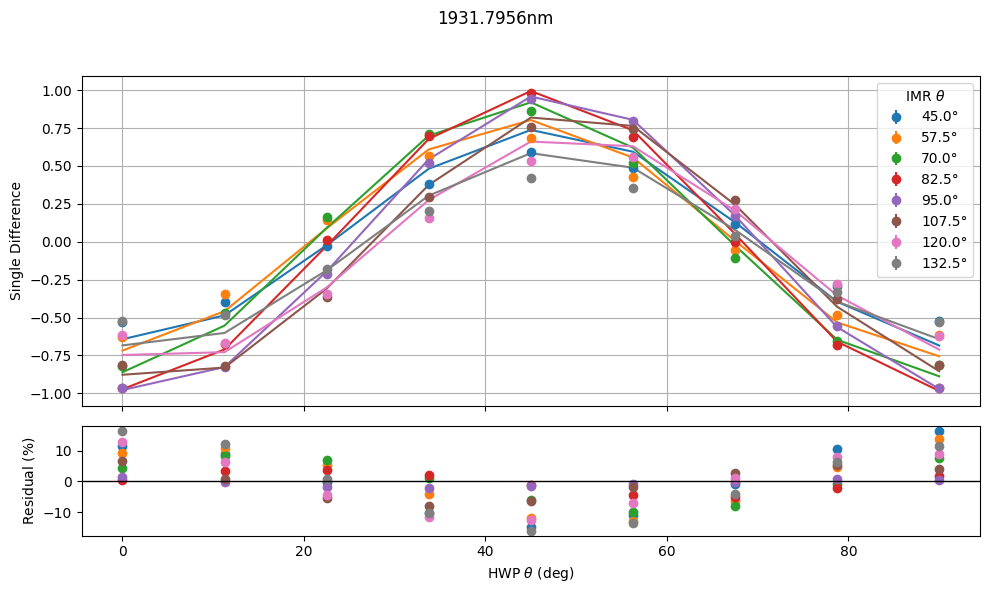

Updated Mueller Matrix:
[[ 0.17858236  0.14132293 -0.10917642  0.        ]
 [-0.17858236 -0.14132293  0.10917642  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.16067574830595682 0.16484429284722524
Error: [ 1.00921892  6.02325332 12.01799983]


array([ 1.00921892,  6.02325332, 12.01799983])

In [53]:
# Test fitting with the wavelength bin we plotted earlier

fit_CHARIS_Mueller_matrix_offsets_by_bin(filepath, 15, 
    Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/just_offsets_dicts/test.json'),
    plot_path=Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/just_offsets_plots/test.png'),)



Looks like our model improved! Note that the Joost't Hart paper used a more elaborate physical model, which I will incorporate later. These fits are a good starting point for more detailed models. Now we can fit for all bins and collect the errors.

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.506e+02 -4.430e+01 ...  2.232e+02  1.515e+01]
           x: [ 1.426e-01  1.265e+00  5.000e+00]
        cost: 9861548.621630676
         jac: [[-1.764e+01 -1.045e+01  1.461e+01]
               [ 1.151e+02 -6.424e+01  4.105e+01]
               ...
               [-1.188e+02  2.022e+01 -2.032e+00]
               [ 1.503e+01 -4.283e+01  3.074e+01]]
        grad: [-2.055e+00 -3.243e+00 -3.679e+04]
  optimality: 12.109698176614542
 active_mask: [0 0 1]
        nfev: 12
        njev: 12
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.506e+02 -4.430e+01 ...  2.232e+02  1.515e+01]
           x: [ 1.426e-01  1.265e+00  5.000e+00]
        cost: 9861548.621596545
         jac: [[-1.764e+01 -1.045e+01  1.461e+01]
               [ 1.151e+02 -6.424e+01  4.105e+01]
               ...
               [-1.188e+02  2.022e+01 -2.032e+00]

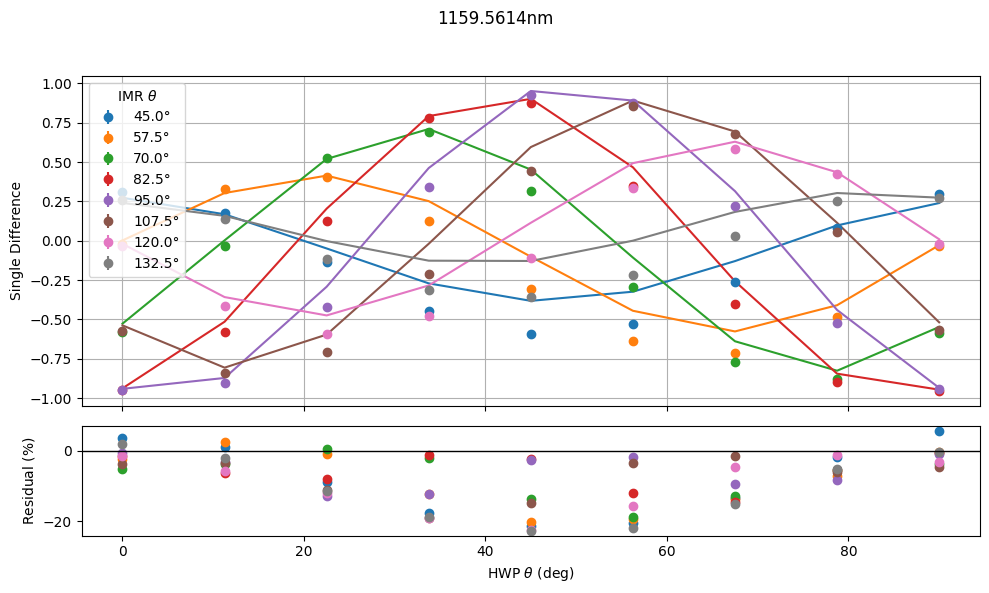

Updated Mueller Matrix:
[[ 0.63696534  0.62728841  0.11060787  0.        ]
 [-0.63696534 -0.62728841 -0.11060787  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.22746342827850735 0.05686911408156037
Error: [ 0.77586488  5.37928805 10.51755392]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.979e+02 -4.637e+02 ... -3.427e+02 -5.991e+02]
           x: [-8.603e-02  6.804e-01  5.000e+00]
        cost: 4407287.446338002
         jac: [[-3.330e+01 -1.604e+00  1.226e+01]
               [ 1.520e+02 -1.202e+02  7.005e+01]
               ...
               [-1.722e+02  8.451e+01 -3.315e+01]
               [ 1.586e+01 -5.052e+01  3.668e+01]]
        grad: [-3.288e-01 -1.438e+01 -2.861e+04]
  optimality: 62.10805101658457
 active_mask: [0 0 1]
        nfev: 14
        njev: 14
     message: `ftol` termination condition is satisfied.
     success: Tru

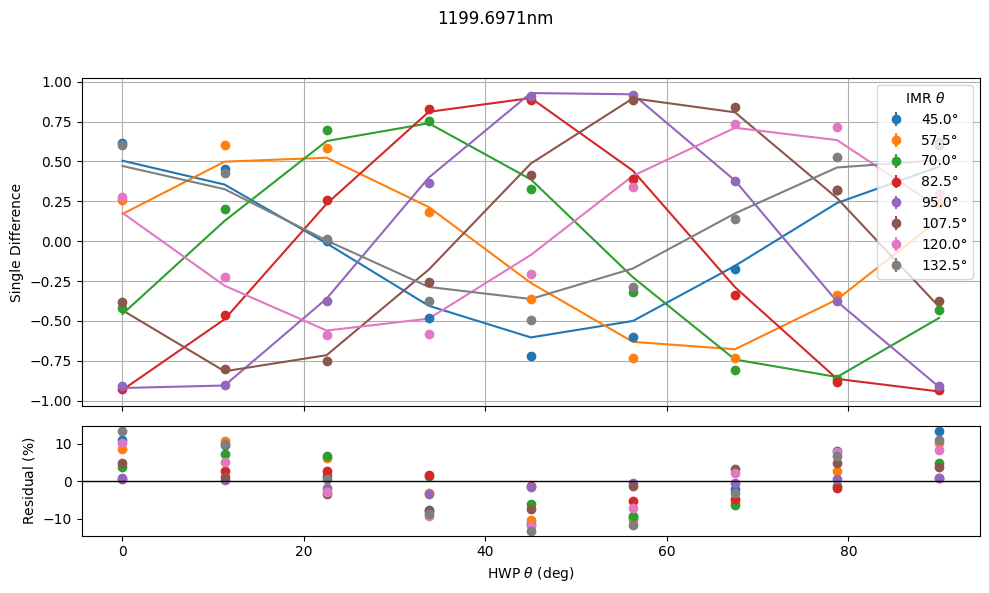

Updated Mueller Matrix:
[[ 0.75417216  0.74271459  0.13096062  0.        ]
 [-0.75417216 -0.74271459 -0.13096062  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.13250144198605107 0.13401800517302798
Error: [0.65314377 3.56519567 6.81924968]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.008e+02 -1.318e+02 ... -6.721e+00 -2.625e+02]
           x: [-1.194e+00 -3.002e-01  5.000e+00]
        cost: 2121460.462795692
         jac: [[-4.992e+01  9.332e+00  8.685e+00]
               [ 2.211e+02 -2.103e+02  1.155e+02]
               ...
               [-2.478e+02  1.805e+02 -8.108e+01]
               [ 3.098e+01 -7.168e+01  4.927e+01]]
        grad: [-1.172e+00 -6.016e+00 -1.161e+04]
  optimality: 31.888218618294665
 active_mask: [0 0 1]
        nfev: 14
        njev: 14
     message: `ftol` termination condition is satisfied.
     success: True


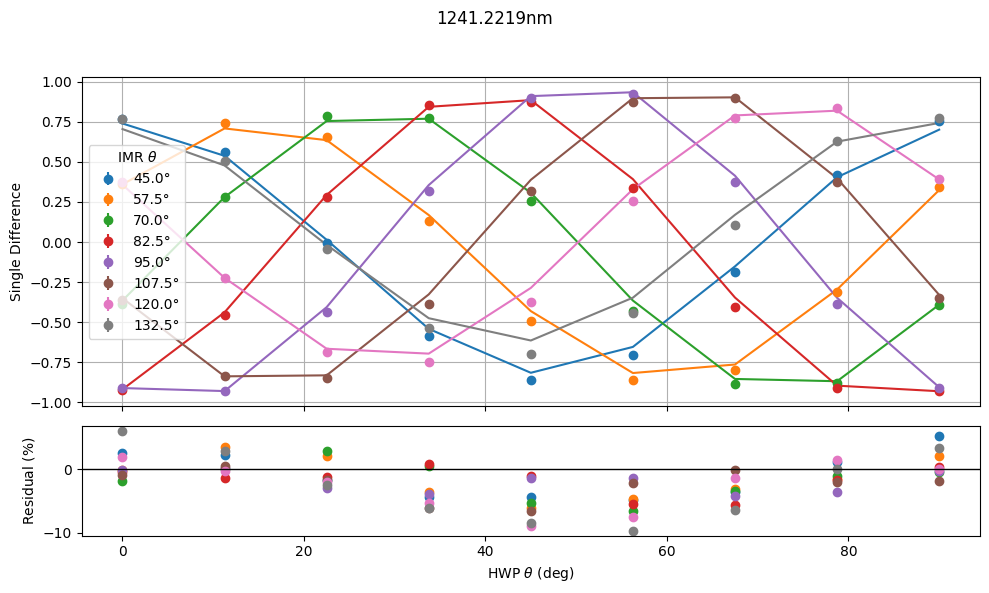

Updated Mueller Matrix:
[[ 0.87136742  0.85812939  0.15131136  0.        ]
 [-0.87136742 -0.85812939 -0.15131136  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.09718343286285147 0.06073002217471091
Error: [0.62426263 2.44671742 4.43127942]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.524e+02  7.322e+01 ...  1.748e+02  7.463e+01]
           x: [-2.618e+00 -5.000e+00 -1.606e+00]
        cost: 1344507.92971983
         jac: [[-8.961e+01  5.032e+01 -1.109e+01]
               [ 3.064e+02 -3.119e+02  1.641e+02]
               ...
               [-3.353e+02  3.006e+02 -1.430e+02]
               [ 5.852e+01 -9.857e+01  6.356e+01]]
        grad: [ 3.250e-01  1.356e+04  1.370e-01]
  optimality: 0.7741837625996666
 active_mask: [ 0 -1  0]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: Tru

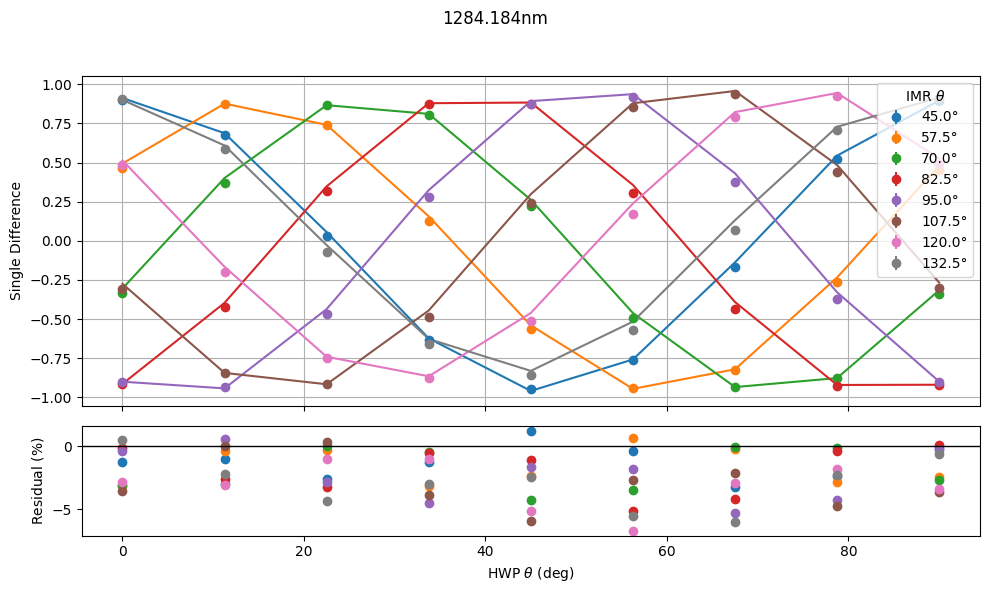

Updated Mueller Matrix:
[[ 0.95786934  0.95636403 -0.05367982  0.        ]
 [-0.95786934 -0.95636403  0.05367982  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.06711534698143415 0.012469927743731235
Error: [1.07821616 2.88858001 4.42695278]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 6.149e+02  2.085e+02 ...  2.711e+02  6.788e+02]
           x: [-5.000e+00 -5.000e+00  3.023e+00]
        cost: 3035669.2413734864
         jac: [[-1.869e+02  1.780e+02 -8.506e+01]
               [ 4.232e+02 -4.259e+02  2.145e+02]
               ...
               [-4.257e+02  4.241e+02 -2.115e+02]
               [ 1.377e+02 -1.441e+02  7.492e+01]]
        grad: [ 6.198e+03  4.501e+03  2.533e+00]
  optimality: 20.322168272138523
 active_mask: [ 0 -1  0]
        nfev: 17
        njev: 17
     message: `ftol` termination condition is satisfied.
     success: 

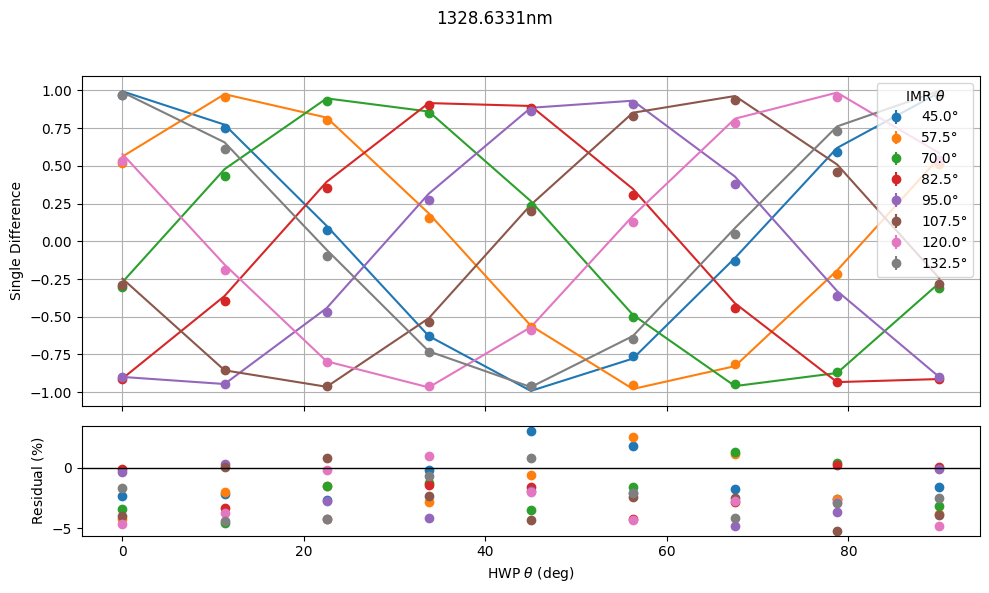

Updated Mueller Matrix:
[[ 0.99818048  0.99262805  0.10513719  0.        ]
 [-0.99818048 -0.99262805 -0.10513719  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.05204761528346041 0.030780120054927584
Error: [10.84281308 22.40544635 24.30502482]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.737e+03  8.720e+02 ...  1.247e+03  2.111e+03]
           x: [ 9.823e-01  2.123e+00  5.000e+00]
        cost: 31794744.62851124
         jac: [[-2.070e+02  2.585e+02 -1.554e+02]
               [ 8.656e+02 -8.188e+02  3.939e+02]
               ...
               [-8.133e+02  8.250e+02 -4.265e+02]
               [ 1.705e+02 -1.194e+02  3.359e+01]]
        grad: [-1.120e+01  1.672e+02 -1.763e+05]
  optimality: 1190.9676325149335
 active_mask: [0 0 1]
        nfev: 19
        njev: 19
     message: `ftol` termination condition is satisfied.
     success: T

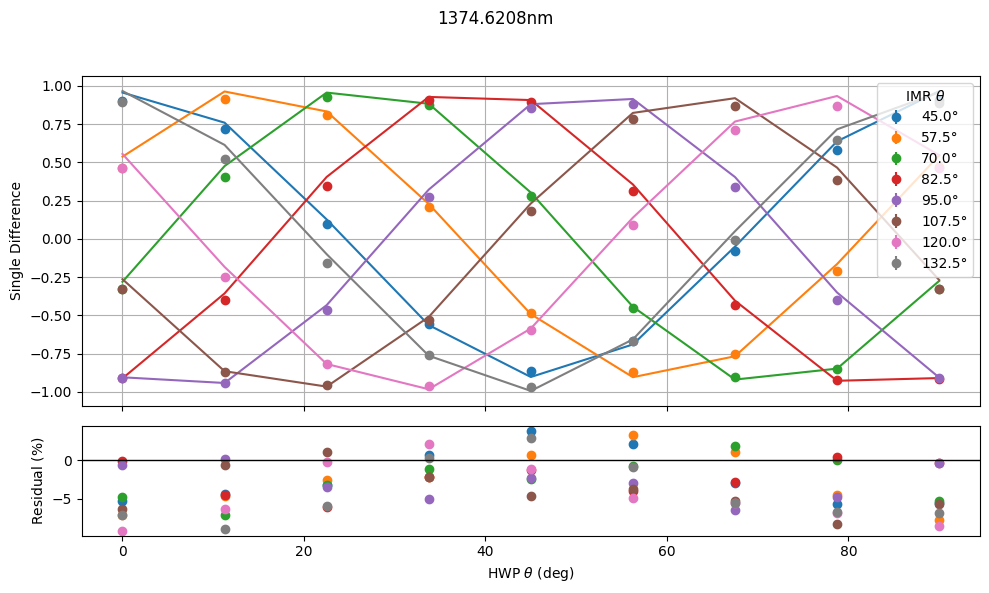

Updated Mueller Matrix:
[[ 0.97912896  0.96425379  0.17002396  0.        ]
 [-0.97912896 -0.96425379 -0.17002396  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.09170333378822543 0.038492857599087826
Error: [ 4.65252876 11.1275075  14.84963313]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.904e+02  6.744e+02 ...  8.717e+02  1.261e+03]
           x: [ 1.489e+00  2.654e+00  5.000e+00]
        cost: 13524526.21546195
         jac: [[-8.486e+01  1.379e+02 -9.487e+01]
               [ 4.939e+02 -3.991e+02  1.787e+02]
               ...
               [-4.626e+02  4.505e+02 -2.438e+02]
               [ 7.388e+01 -2.160e+01 -1.489e+01]]
        grad: [ 3.209e+00  1.154e+01 -8.740e+04]
  optimality: 88.31607151037358
 active_mask: [0 0 1]
        nfev: 14
        njev: 14
     message: `ftol` termination condition is satisfied.
     success: Tr

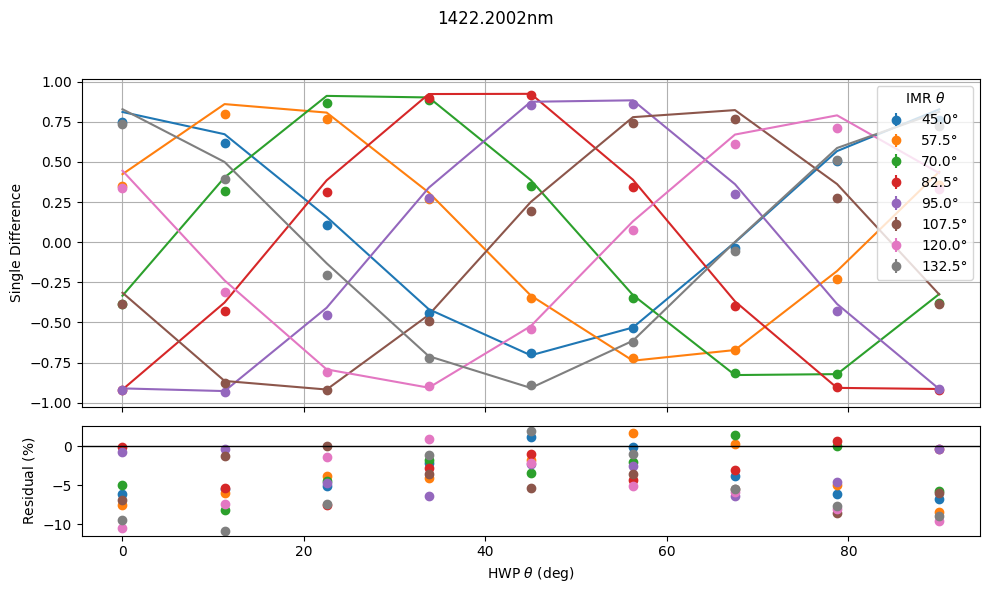

Updated Mueller Matrix:
[[ 0.90574956  0.89198919  0.15728176  0.        ]
 [-0.90574956 -0.89198919 -0.15728176  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.10834014151664634 0.01899530952656081
Error: [1.18317124 3.71558626 6.21066642]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.816e+02  3.539e+02 ...  5.243e+02  7.511e+02]
           x: [ 6.274e-01  1.871e+00  5.000e+00]
        cost: 5988515.570797621
         jac: [[-5.436e+01  1.054e+02 -8.142e+01]
               [ 3.842e+02 -2.315e+02  8.940e+01]
               ...
               [-3.660e+02  3.070e+02 -1.768e+02]
               [ 5.502e+01 -4.488e+00 -2.650e+01]]
        grad: [-4.921e-01 -6.480e-01 -8.962e+03]
  optimality: 2.1516139869717015
 active_mask: [0 0 1]
        nfev: 16
        njev: 16
     message: `ftol` termination condition is satisfied.
     success: True


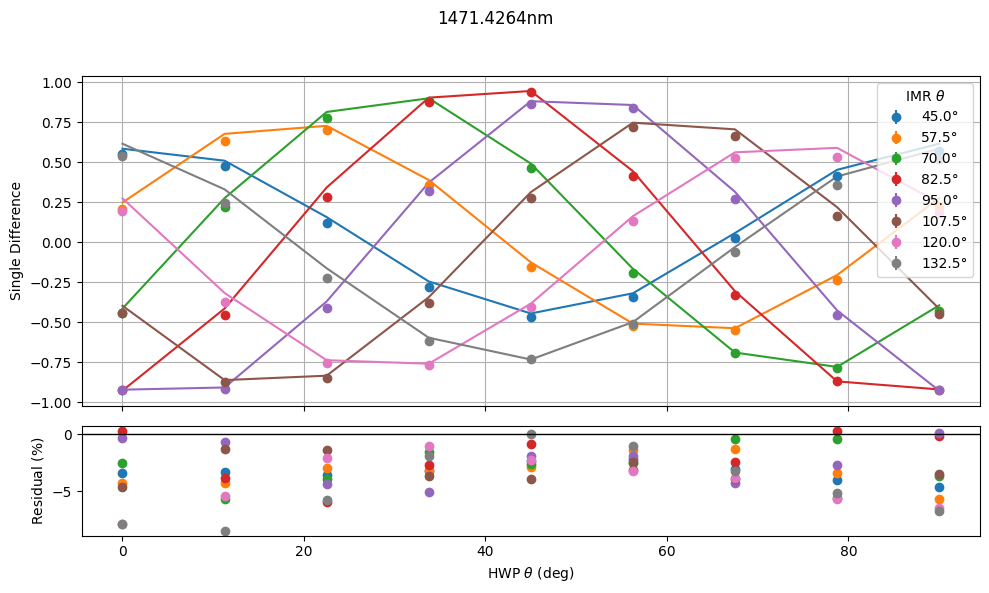

Updated Mueller Matrix:
[[ 0.79176824  0.77973951  0.13748911  0.        ]
 [-0.79176824 -0.77973951 -0.13748911  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.08466403076631118 0.0031961341165499535
Error: [0.41974931 1.73630165 3.16871033]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.559e+02  2.071e+02 ...  3.959e+02  5.133e+02]
           x: [ 1.999e-01 -2.045e-01  1.545e+00]
        cost: 4544231.2000832185
         jac: [[-3.709e+01  7.982e+01 -6.854e+01]
               [ 2.911e+02 -9.736e+01  2.179e+01]
               ...
               [-2.829e+02  1.743e+02 -1.125e+02]
               [ 4.236e+01  4.944e-01 -2.908e+01]]
        grad: [-7.484e-01  7.798e-01 -1.084e+00]
  optimality: 3.7445507268244493
 active_mask: [0 0 0]
        nfev: 11
        njev: 11
     message: `ftol` termination condition is satisfied.
     success: Tr

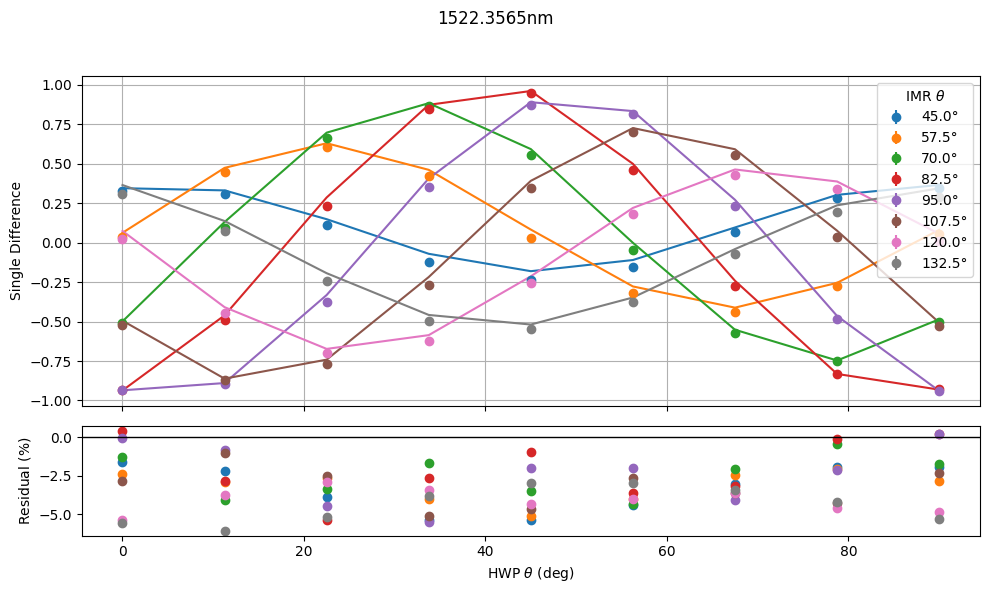

Updated Mueller Matrix:
[[ 0.67246797  0.67148987  0.0362565   0.        ]
 [-0.67246797 -0.67148987 -0.0362565   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.060842551568602535 0.004331606602861471
Error: [0.27096733 1.34491798 2.54388249]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.996e+02 -3.741e+01 ...  1.764e+02  1.499e+02]
           x: [-8.347e-02 -2.707e+00 -2.843e+00]
        cost: 6651005.129617674
         jac: [[-3.314e+01  6.840e+01 -6.606e+01]
               [ 2.529e+02  7.678e+00 -3.325e+01]
               ...
               [-2.529e+02  6.807e+01 -6.371e+01]
               [ 3.602e+01 -1.434e-01 -3.220e+01]]
        grad: [ 3.655e-01  3.436e+01 -1.789e+01]
  optimality: 140.27615354094402
 active_mask: [0 0 0]
        nfev: 12
        njev: 12
     message: `ftol` termination condition is satisfied.
     success: Tru

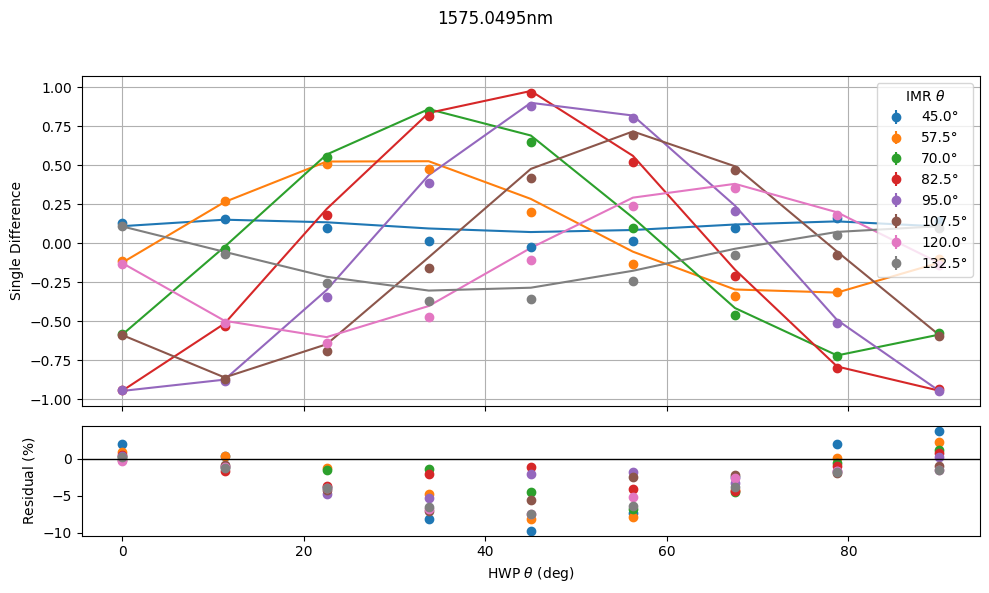

Updated Mueller Matrix:
[[ 0.55472358  0.5519947  -0.05495543  0.        ]
 [-0.55472358 -0.5519947   0.05495543  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.09713175716028363 0.03784931573208605
Error: [0.2522466  1.38210943 2.66660608]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.582e+02 -3.227e+02 ... -4.996e+01 -2.117e+02]
           x: [-2.894e-01 -3.215e+00 -3.452e+00]
        cost: 9695469.542494547
         jac: [[-3.040e+01  5.474e+01 -6.307e+01]
               [ 2.317e+02  1.159e+02 -9.071e+01]
               ...
               [-2.351e+02 -5.331e+01 -6.839e+00]
               [ 3.341e+01 -8.498e+00 -3.206e+01]]
        grad: [ 3.475e+00  6.992e+01 -3.546e+01]
  optimality: 299.708583419436
 active_mask: [0 0 0]
        nfev: 13
        njev: 13
     message: `ftol` termination condition is satisfied.
     success: True
  

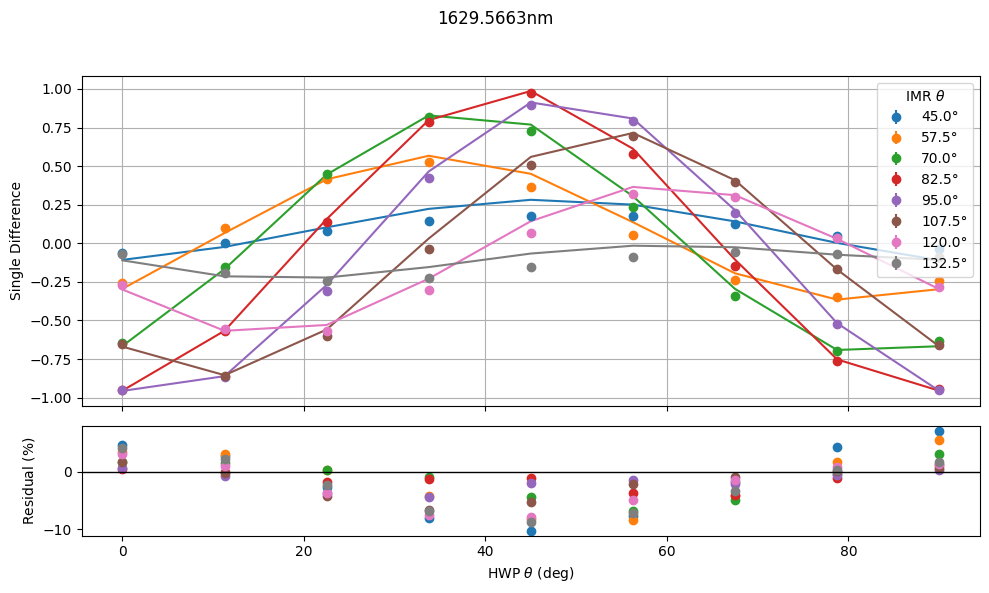

Updated Mueller Matrix:
[[ 0.44613666  0.44290176 -0.0536279   0.        ]
 [-0.44613666 -0.44290176  0.0536279   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.10252166309183691 0.07194737263945067
Error: [0.25916778 1.45838431 2.84710329]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-8.021e+02 -5.163e+02 ... -2.440e+02 -5.393e+02]
           x: [-3.939e-01 -4.087e+00 -5.000e+00]
        cost: 14055641.550752705
         jac: [[-2.431e+01  3.191e+01 -4.924e+01]
               [ 1.834e+02  1.999e+02 -1.298e+02]
               ...
               [-1.871e+02 -1.655e+02  5.158e+01]
               [ 2.709e+01 -1.914e+01 -2.436e+01]]
        grad: [ 3.028e-01  5.400e+01  8.474e+03]
  optimality: 49.291969956580665
 active_mask: [ 0  0 -1]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: T

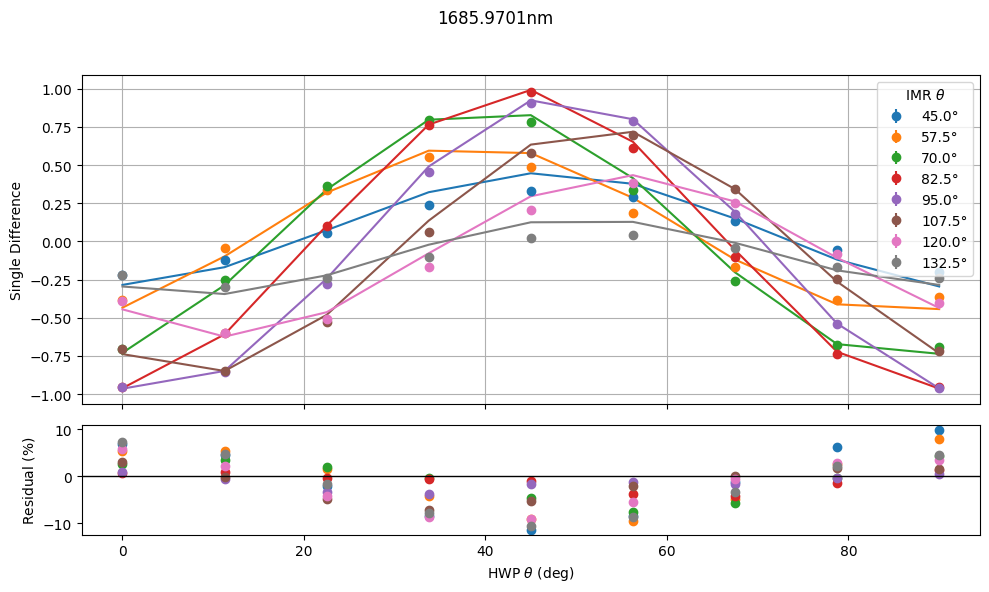

Updated Mueller Matrix:
[[ 0.35761936  0.35218632 -0.06209995  0.        ]
 [-0.35761936 -0.35218632  0.06209995  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.11398348248652618 0.09783220439989254
Error: [0.34105534 1.87587498 3.6906148 ]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.141e+03 -7.377e+02 ... -4.521e+02 -9.336e+02]
           x: [-3.429e-01 -4.167e+00 -5.000e+00]
        cost: 26718209.456960425
         jac: [[-2.373e+01  1.341e+01 -3.907e+01]
               [ 1.573e+02  2.832e+02 -1.702e+02]
               ...
               [-1.637e+02 -2.724e+02  1.065e+02]
               [ 2.156e+01 -3.195e+01 -1.704e+01]]
        grad: [-5.067e-01  9.123e+01  1.017e+05]
  optimality: 76.02052349242365
 active_mask: [ 0  0 -1]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: Tr

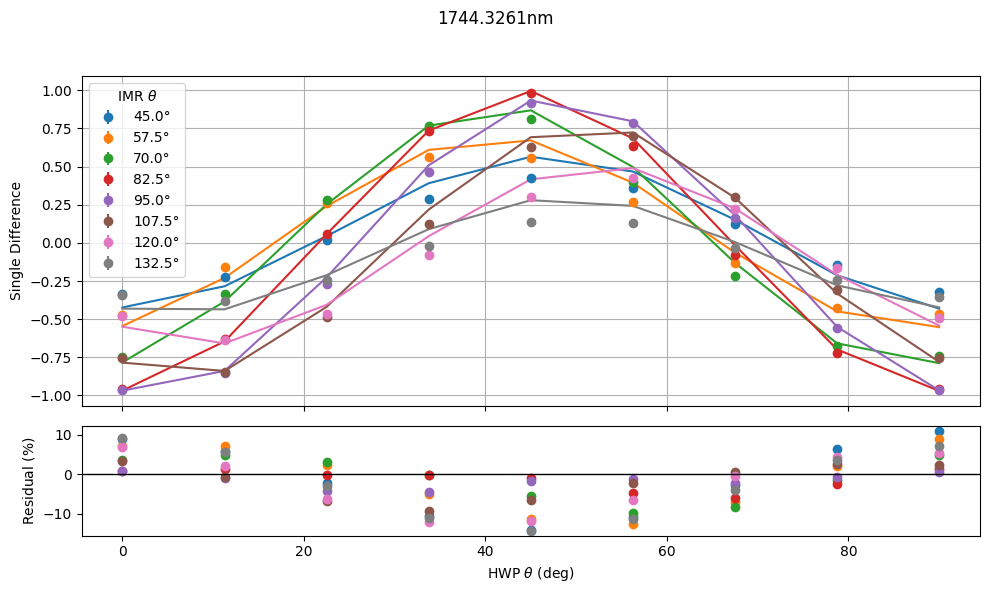

Updated Mueller Matrix:
[[ 0.28857544  0.28419133 -0.0501106   0.        ]
 [-0.28857544 -0.28419133  0.0501106   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.14345140442195523 0.10985086628259827
Error: [0.50183356 2.66512393 5.27164234]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.108e+03 -1.501e+03 ... -1.024e+03 -1.937e+03]
           x: [-3.726e-01 -4.291e+00 -5.000e+00]
        cost: 66294042.4004125
         jac: [[-2.949e+01 -1.509e+01 -3.204e+01]
               [ 1.788e+02  4.646e+02 -2.667e+02]
               ...
               [-1.878e+02 -4.910e+02  2.101e+02]
               [ 2.305e+01 -6.848e+01 -6.079e+00]]
        grad: [-3.568e+00  1.293e+02  2.261e+05]
  optimality: 91.73059231464352
 active_mask: [ 0  0 -1]
        nfev: 16
        njev: 16
     message: `ftol` termination condition is satisfied.
     success: True

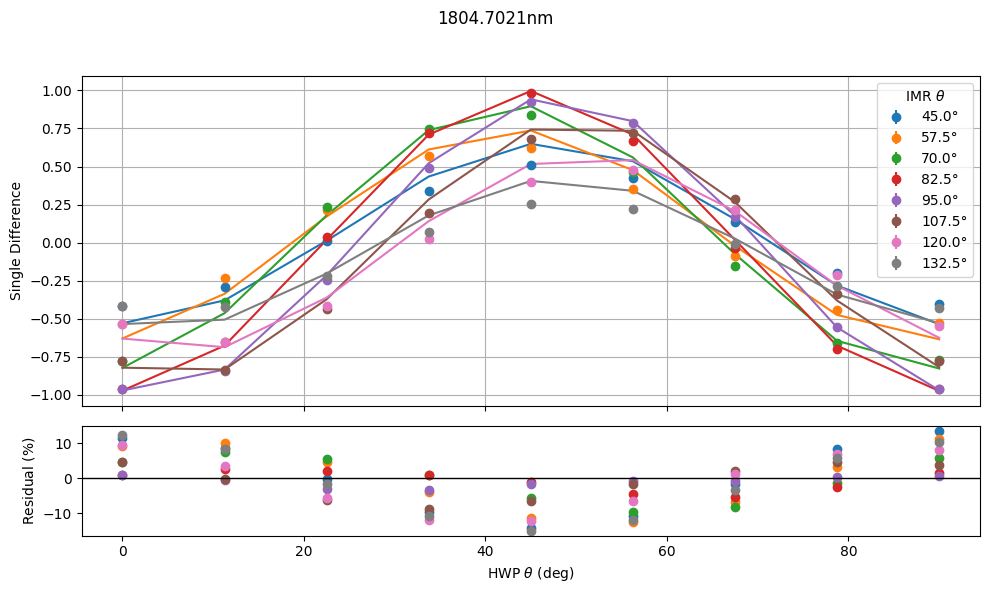

Updated Mueller Matrix:
[[ 0.23537876  0.23180283 -0.04087309  0.        ]
 [-0.23537876 -0.23180283  0.04087309  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.15004516118326633 0.13490341310751586
Error: [0.66181869 3.4727563  6.89427755]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.967e+03 -2.741e+03 ... -1.979e+03 -3.883e+03]
           x: [-3.096e-01 -4.326e+00 -5.000e+00]
        cost: 246563371.733775
         jac: [[-4.963e+01 -7.781e+01 -2.284e+01]
               [ 2.744e+02  9.512e+02 -5.284e+02]
               ...
               [-2.895e+02 -1.054e+03  4.735e+02]
               [ 3.298e+01 -1.628e+02  1.862e+01]]
        grad: [ 2.871e+01  2.735e+03  7.102e+05]
  optimality: 1843.6640438539089
 active_mask: [ 0  0 -1]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: Tru

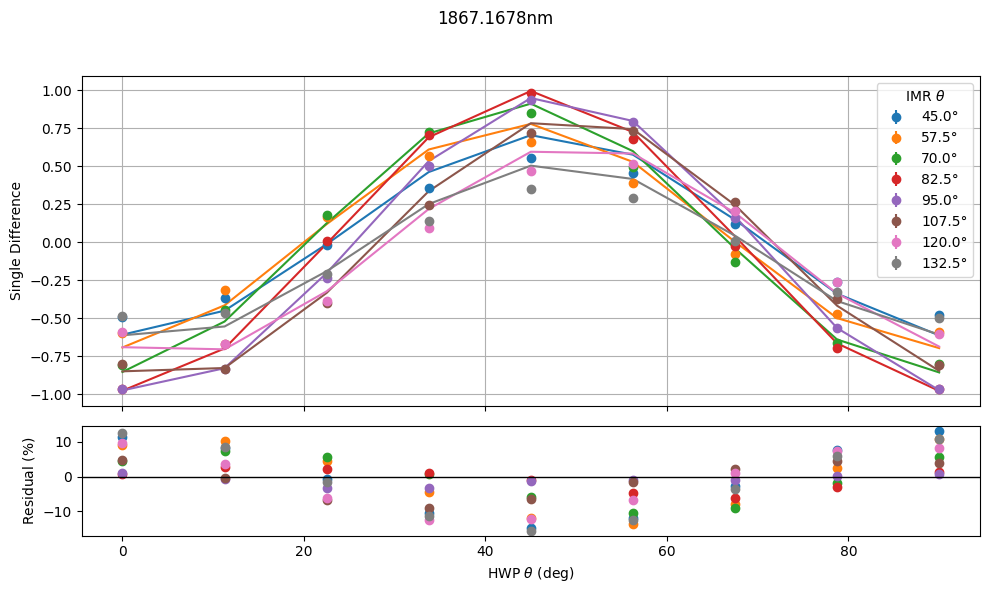

Updated Mueller Matrix:
[[ 0.19647546  0.19349055 -0.03411761  0.        ]
 [-0.19647546 -0.19349055  0.03411761  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.15618925021940072 0.132376781829673
Error: [0.80741241 4.34759563 8.65392121]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.114e+03 -2.281e+03 ... -1.727e+03 -3.198e+03]
           x: [-2.908e-01 -4.364e+00 -5.000e+00]
        cost: 129169022.41397059
         jac: [[-2.953e+01 -8.288e+01  8.951e+00]
               [ 1.553e+02  6.665e+02 -3.608e+02]
               ...
               [-1.633e+02 -7.672e+02  3.561e+02]
               [ 1.774e+01 -1.316e+02  3.300e+01]]
        grad: [ 3.746e+00  1.643e+03  3.212e+05]
  optimality: 1045.1726369831981
 active_mask: [ 0  0 -1]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: Tru

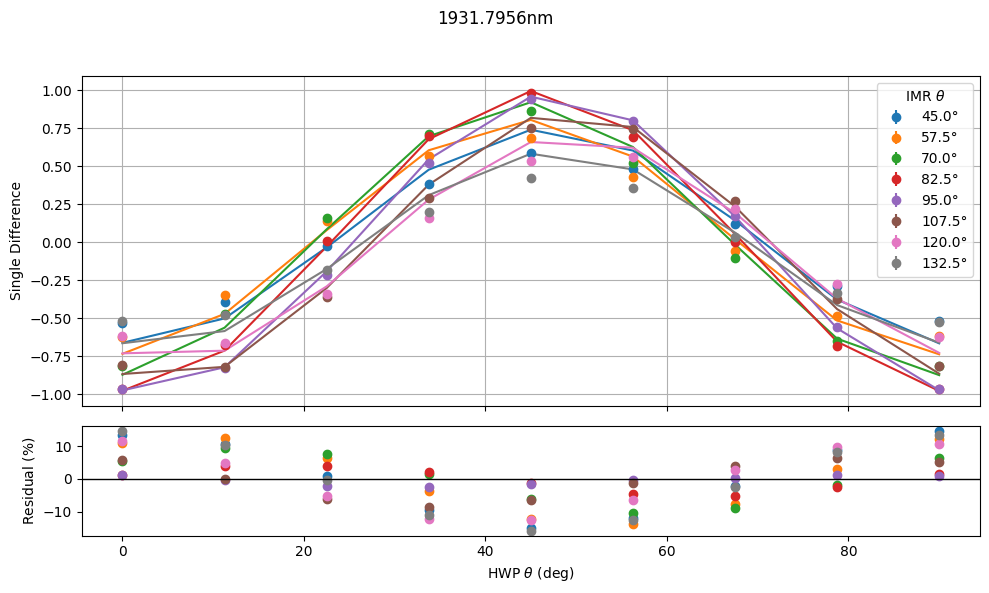

Updated Mueller Matrix:
[[ 0.16889275  0.16632689 -0.02932792  0.        ]
 [-0.16889275 -0.16632689  0.02932792  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.15816115613412257 0.14648118401257448
Error: [ 1.01700859  6.03940673 12.04329643]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.068e+03 -2.246e+03 ... -1.703e+03 -3.232e+03]
           x: [-2.129e-01 -4.426e+00 -5.000e+00]
        cost: 122887175.96238567
         jac: [[-2.571e+01 -1.006e+02  2.901e+01]
               [ 1.224e+02  6.147e+02 -3.253e+02]
               ...
               [-1.298e+02 -7.317e+02  3.481e+02]
               [ 1.201e+01 -1.395e+02  4.835e+01]]
        grad: [-6.301e+00  4.560e+02  2.344e+05]
  optimality: 261.90469138527686
 active_mask: [ 0  0 -1]
        nfev: 16
        njev: 16
     message: `ftol` termination condition is satisfied.
     success

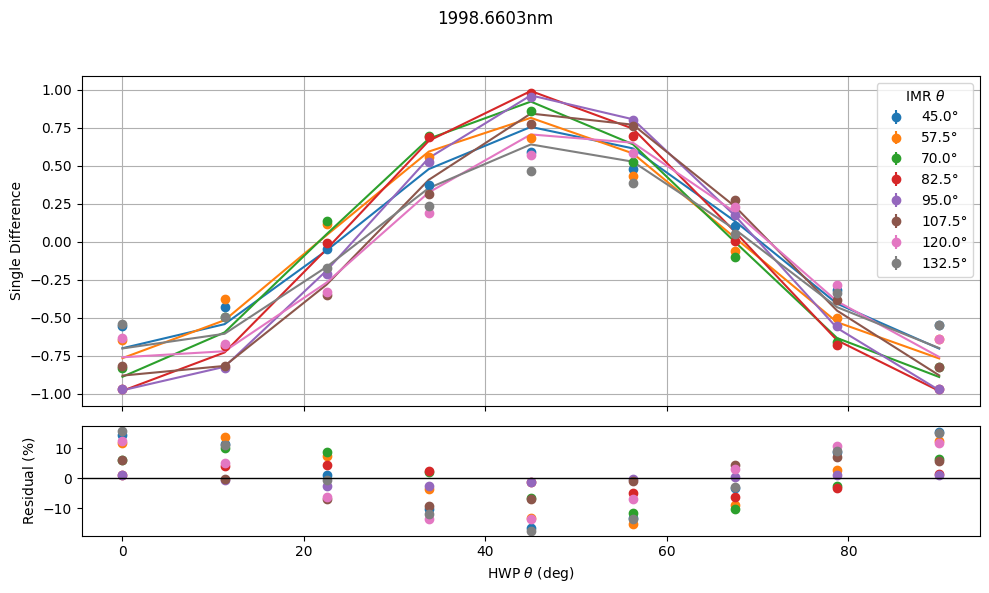

Updated Mueller Matrix:
[[ 0.15043044  0.14814506 -0.02612197  0.        ]
 [-0.15043044 -0.14814506  0.02612197  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.17476357249091212 0.15821482881337245
Error: [ 1.24128078  9.0333966  18.03842175]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.088e+03 -2.328e+03 ... -1.837e+03 -3.350e+03]
           x: [-1.657e-01 -4.474e+00 -5.000e+00]
        cost: 121691255.37434042
         jac: [[-2.336e+01 -1.163e+02  4.594e+01]
               [ 1.046e+02  5.784e+02 -2.995e+02]
               ...
               [-1.110e+02 -7.120e+02  3.460e+02]
               [ 9.025e+00 -1.492e+02  6.241e+01]]
        grad: [-1.254e+01  7.580e+02  1.302e+05]
  optimality: 398.76293058442667
 active_mask: [ 0  0 -1]
        nfev: 16
        njev: 16
     message: `ftol` termination condition is satisfied.
     success

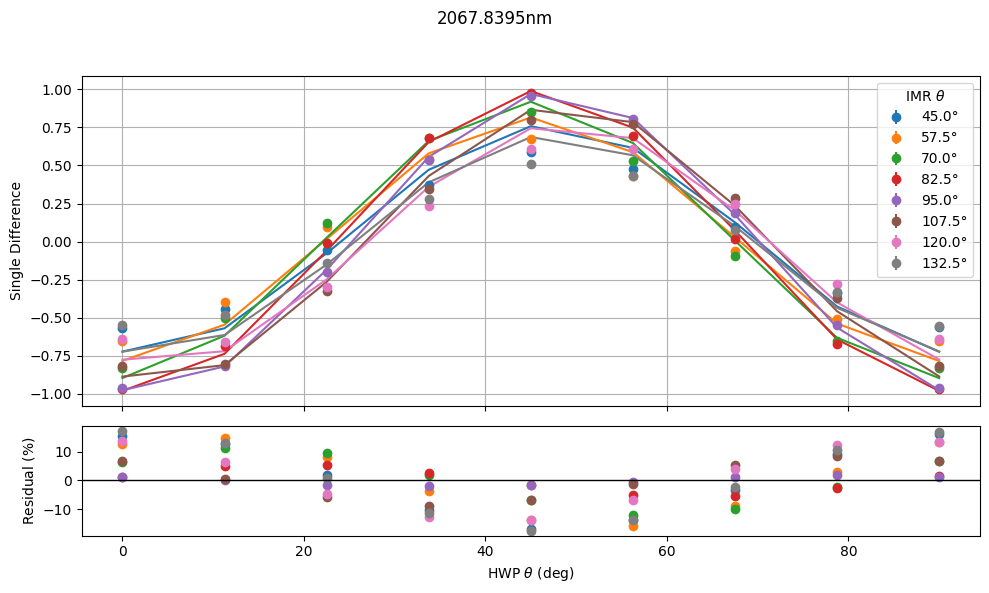

Updated Mueller Matrix:
[[ 0.13884847  0.13673905 -0.02411078  0.        ]
 [-0.13884847 -0.13673905  0.02411078  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.17581465982658007 0.1737758972568575
Error: [ 1.44650045 15.75870875 31.49695134]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.890e+03 -2.200e+03 ... -1.795e+03 -3.208e+03]
           x: [-1.523e-01 -4.473e+00 -5.000e+00]
        cost: 106566149.44757962
         jac: [[-2.001e+01 -1.201e+02  5.650e+01]
               [ 8.915e+01  5.143e+02 -2.602e+02]
               ...
               [-9.351e+01 -6.524e+02  3.233e+02]
               [ 7.498e+00 -1.477e+02  7.027e+01]]
        grad: [ 2.439e+01  5.496e+02  3.674e+04]
  optimality: 289.76788912732997
 active_mask: [ 0  0 -1]
        nfev: 16
        njev: 16
     message: `ftol` termination condition is satisfied.
     success:

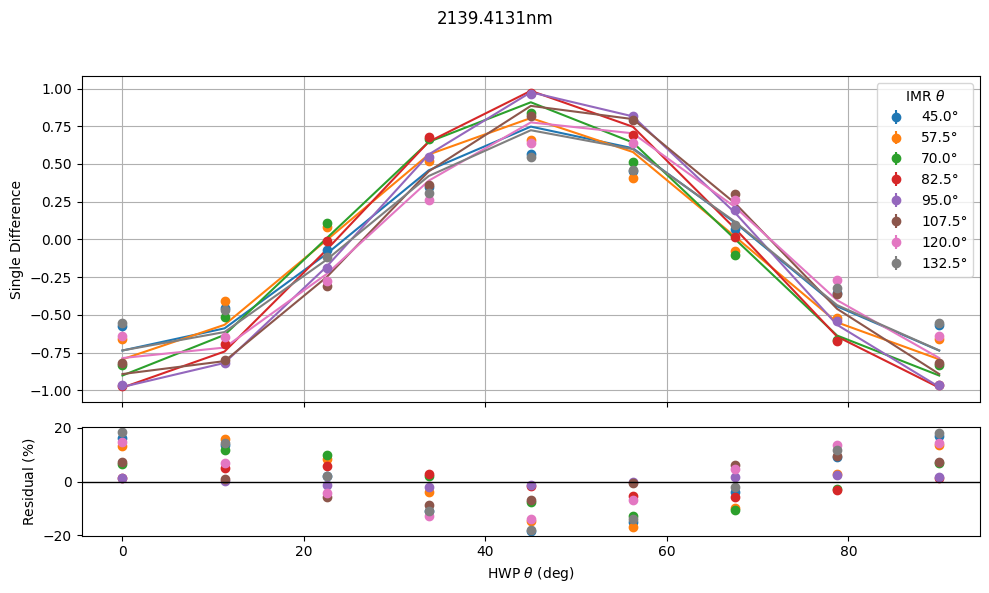

Updated Mueller Matrix:
[[ 0.13243765  0.13042562 -0.02299756  0.        ]
 [-0.13243765 -0.13042562  0.02299756  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.18262414329767895 0.1851136518394425
Error: [  1.59443057  50.2615894  100.51207149]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.030e+03 -2.446e+03 ... -2.122e+03 -3.388e+03]
           x: [-9.228e-02  5.353e-01  5.000e+00]
        cost: 108600263.757016
         jac: [[-1.772e+01 -1.196e+02  6.368e+01]
               [ 7.747e+01  4.506e+02 -2.217e+02]
               ...
               [-8.140e+01 -5.962e+02  3.011e+02]
               [ 6.054e+00 -1.428e+02  7.526e+01]]
        grad: [ 1.076e+02 -1.014e+02 -3.717e+04]
  optimality: 528.1110434128577
 active_mask: [0 0 1]
        nfev: 15
        njev: 15
     message: `ftol` termination condition is satisfied.
     success: Tr

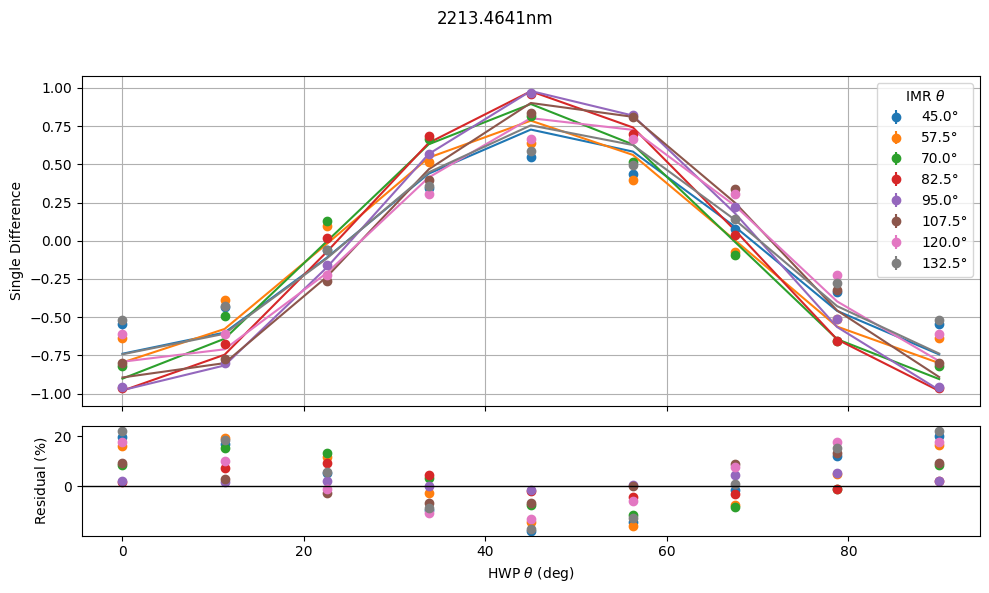

Updated Mueller Matrix:
[[ 0.13067704  0.12869176  0.02269183  0.        ]
 [-0.13067704 -0.12869176 -0.02269183  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1793996507946073 0.2216321210746499
Error: [ 1.85124346 46.20629162 92.41395258]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.375e+03 -1.844e+03 ... -1.551e+03 -2.719e+03]
           x: [-1.960e-01  5.426e-01  5.000e+00]
        cost: 80166203.3555341
         jac: [[-1.471e+01 -1.181e+02  6.943e+01]
               [ 6.961e+01  3.795e+02 -1.801e+02]
               ...
               [-7.012e+01 -5.235e+02  2.696e+02]
               [ 6.528e+00 -1.384e+02  7.951e+01]]
        grad: [ 1.697e+01 -1.550e+02 -7.597e+04]
  optimality: 690.8055673367758
 active_mask: [0 0 1]
        nfev: 14
        njev: 14
     message: `ftol` termination condition is satisfied.
     success: True
 

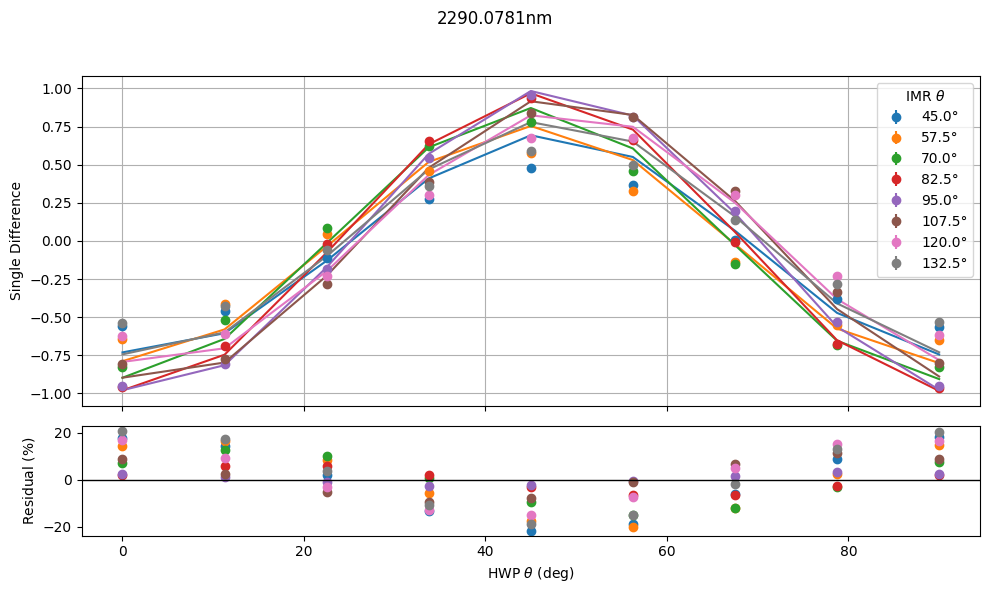

Updated Mueller Matrix:
[[ 0.13483286  0.13278445  0.02341348  0.        ]
 [-0.13483286 -0.13278445 -0.02341348  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.21717715362821988 0.20742072076714713
Error: [ 1.84421804 14.96657781 29.91989131]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.951e+03 -2.557e+03 ... -2.502e+03 -3.267e+03]
           x: [ 6.407e-01  5.279e-01  5.000e+00]
        cost: 104836156.9532575
         jac: [[-1.727e+01 -9.610e+01  6.220e+01]
               [ 5.238e+01  2.850e+02 -1.290e+02]
               ...
               [-6.234e+01 -4.237e+02  2.232e+02]
               [-3.630e-01 -1.120e+02  7.002e+01]]
        grad: [-1.433e+02  1.632e+02 -1.088e+05]
  optimality: 902.3629045372079
 active_mask: [0 0 1]
        nfev: 14
        njev: 14
     message: `ftol` termination condition is satisfied.
     success: Tru

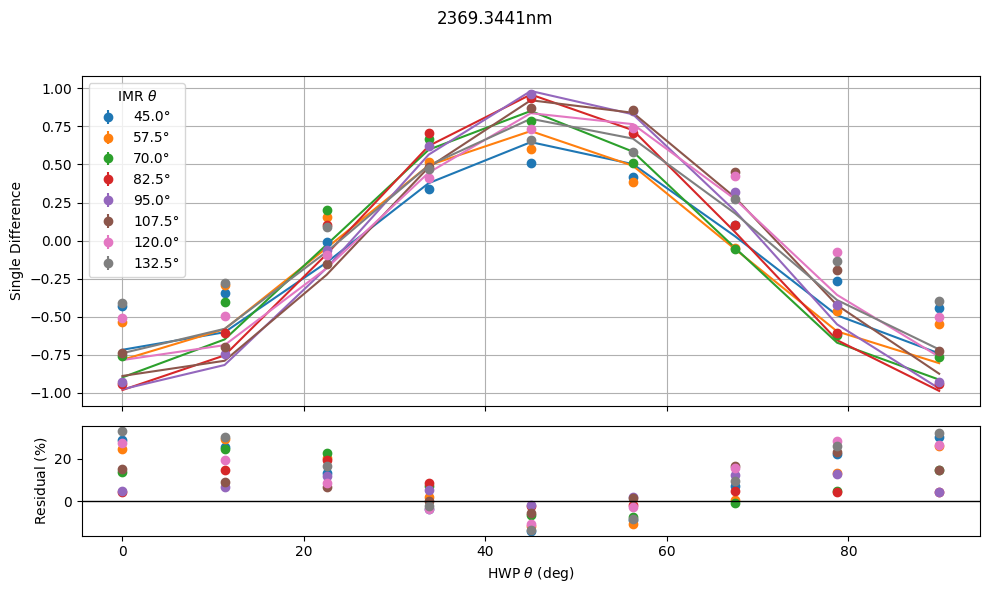

Updated Mueller Matrix:
[[ 0.1426044   0.14043792  0.02476299  0.        ]
 [-0.1426044  -0.14043792 -0.02476299  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Residuals range: -0.1382852344193184 0.3313351791566596
Error: [ 2.48860703 12.51278911 24.96847596]


In [39]:
# Fit all 22 wavelength bins
errors = []
for bin in range(0,22):
 # Test fitting with the wavelength bin we plotted earlier

 error = fit_CHARIS_Mueller_matrix_offsets_by_bin(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv', bin, 
        Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/just_offsets_dicts/bin{bin}.json'),
        plot_path=Path(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/just_offsets_plots/bin{bin}.png'),)


errors.append(error)


In [47]:
# find average error
errors = np.array(errors)
print('hwp_ret', np.mean(errors[:,0]))
print('hwp_offset', np.mean(errors[:,1]))
print('imr_ret',np.mean(errors[:,2]))
print('imr_offset', np.mean(errors[:,3]))
print('epsilon_cal', np.mean(errors[:,4]))
print('cal_offset', np.mean(errors[:,5]))



    

hwp_ret 0.014692726669859945
hwp_offset 0.7860982700240057
imr_ret 0.013974253086916555
imr_offset 6.560003448576396
epsilon_cal 0.005400227789223019
cal_offset 12.755609199408884


In [48]:
# Now let's make a dataframe of our data, this model data function can be changed easily to include
# whatever parameters you're fitting
json_dir = '/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_with_pickoff_cal'
df = model_data(json_dir)
df

wavelength_bin  hwp_retardance  imr_retardance  \
0        1159.5614        2.995998        4.327645   
1        1199.6971        2.990198        4.042960   
2        1241.2219        2.992739        3.821016   
3        1284.1840        3.004550        3.560275   
4        1328.6331        3.116225        3.331576   
5        1374.6208        2.979048        2.727681   
6        1422.2002        2.954396        2.455550   
7        1471.4264        2.954115        2.183719   
8        1522.3565        2.951260        1.933722   
9        1575.0495        2.953121        1.722730   
10       1629.5663        2.959990        1.524937   
11       1685.9701        2.968946        1.362616   
12       1744.3261        2.979959        1.243209   
13       1804.7021        2.995810        1.148373   
14       1867.1678        3.016409        1.035290   
15       1931.7956        3.036755        0.947384   
16       1998.6603        3.058509        0.883334   
17       2067.8395        3.091634        0.839936   
18       2139.4131        3.131769        0.814041   
19       2213.4641        3.178404        0.800300   
20       2290.0781        3.240202        0.802597   
21       2369.3441        3.260197        0.815376   

    calibration_polarizer_diattenuation  hwp_offset  hwp_offset_std  \
0                              1.000000   -1.434029        2.543711   
1                              0.992221   -1.434029        2.543711   
2                              0.997484   -1.434029        2.543711   
3                              0.992207   -1.434029        2.543711   
4                              0.987633   -1.434029        2.543711   
5                              0.995427   -1.434029        2.543711   
6                              0.997211   -1.434029        2.543711   
7                              0.995466   -1.434029        2.543711   
8                              0.994209   -1.434029        2.543711   
9                              0.994495   -1.434029        2.543711   
10                             0.993138   -1.434029        2.543711   
11                             0.993195   -1.434029        2.543711   
12                             0.993974   -1.434029        2.543711   
13                             0.993062   -1.434029        2.543711   
14                             0.989366   -1.434029        2.543711   
15                             0.981801   -1.434029        2.543711   
16                             0.977026   -1.434029        2.543711   
17                             0.969191   -1.434029        2.543711   
18                             0.965189   -1.434029        2.543711   
19                             0.954746   -1.434029        2.543711   
20                             0.948713   -1.434029        2.543711   
21                             0.929726   -1.434029        2.543711   

    imr_offset  imr_offset_std  cal_offset  cal_offset_std  
0    -0.014993        1.376958    0.187604        3.372732  
1    -0.014993        1.376958    0.187604        3.372732  
2    -0.014993        1.376958    0.187604        3.372732  
3    -0.014993        1.376958    0.187604        3.372732  
4    -0.014993        1.376958    0.187604        3.372732  
5    -0.014993        1.376958    0.187604        3.372732  
6    -0.014993        1.376958    0.187604        3.372732  
7    -0.014993        1.376958    0.187604        3.372732  
8    -0.014993        1.376958    0.187604        3.372732  
9    -0.014993        1.376958    0.187604        3.372732  
10   -0.014993        1.376958    0.187604        3.372732  
11   -0.014993        1.376958    0.187604        3.372732  
12   -0.014993        1.376958    0.187604        3.372732  
13   -0.014993        1.376958    0.187604        3.372732  
14   -0.014993        1.376958    0.187604        3.372732  
15   -0.014993        1.376958    0.187604        3.372732  
16   -0.014993        1.376958    0.187604        3.372732  
17   -0.014993        1.37695

# Step 5: Refine Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [49]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    logl_hwp = np.sum(residuals_hwp**2)
    logl_imr = np.sum(residuals_imr**2)
    return logl_hwp + logl_imr

In [50]:
errors = np.array(errors)
print('hwp_ret', np.mean(errors[:,0]))
print('hwp_offset', np.mean(errors[:,1]))
print('imr_ret',np.mean(errors[:,2]))
print('imr_offset', np.mean(errors[:,3]))
print('epsilon_cal', np.mean(errors[:,4]))
print('cal_offset', np.mean(errors[:,5]))




hwp_ret 0.014692726669859945
hwp_offset 0.7860982700240057
imr_ret 0.013974253086916555
imr_offset 6.560003448576396
epsilon_cal 0.005400227789223019
cal_offset 12.755609199408884


In [51]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_retardance'].values
imr_retardance = df['imr_retardance'].values
hwp_errors = errors[:,0] 
imr_errors = errors[:,2]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds)
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)




  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5910.494678086669
        x: [ 1.656e+00  1.292e+00  2.571e+02]
      nit: 10
      jac: [ 3.251e-01 -4.227e-01 -1.000e-03]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5910.4946780866585
        x: [ 1.656e+00  1.292e+00  2.571e+02]
      nit: 1
      jac: [ 3.225e-01 -4.176e-01 -1.000e-03]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


That's It! The fit is updated. However, in the Hart 2021 paper, a degeneracy in wavelength bin 4 was noted. Because of this, I will redo the fit to see if the model fits better. 

In [52]:
wavelength_bins[4]

1328.6331

In [40]:
# Redo the fit without the degenerate point (bin 4)

wavelengths2 = np.delete(wavelength_bins, 4)
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), 4, axis=0)
hwp_retardances2 = df['hwp_retardance'].values
imr_retardance2 = df['imr_retardance'].values
hwp_errors2 = errors2[:,0] 
imr_errors2 = errors2[:,2]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, 4)
imr_retardance2= np.delete(imr_retardance2,4)

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5811.103663670261
        x: [ 1.656e+00  1.293e+00  2.570e+02]
      nit: 10
      jac: [ 5.723e-01 -7.417e-01  4.275e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5811.103663670211
        x: [ 1.656e+00  1.293e+00  2.570e+02]
      nit: 1
      jac: [ 8.185e-03  1.564e-02  1.091e-02]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [41]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 12691.82161666812
Our model with all bins: 5910.4946780866585
Our model without bin 4: 5811.103663670211
